In [1]:

import os
import pandas as pd
import numpy as np
import rasterio

In [4]:
import os
test = "../test"
os.makedirs(test)

In [2]:
def load_data(paths):
    # Get a list of all files in the directory (X_train, y_train, X_test)
    file_list = [[file for file in os.listdir(paths) if file.endswith('.tif')] for paths in directory_paths]

    # Sort the file list to ensure consistent order
    file_list = [sorted(files) for files in file_list]

    # Initialize an empty array to store the image data
    X_train, y_train, X_test = [], [], []


    # Iterate through the selected files
    for X_train_name, y_train_name in zip(file_list[0], file_list[1]):
        # Construct the full path to the file
        X_train_path = os.path.join(paths[0], X_train_name)
        y_train_path = os.path.join(paths[1], y_train_name)

        # Open the raster file using rasterio
        with rasterio.open(X_train_path) as src:
            # Read the entire image data as a NumPy array
            image_data = src.read()

            # Append the image data to the array
            X_train.append(image_data)

        # Open the raster file using rasterio
        with rasterio.open(y_train_path) as src:
            # Read the entire image data as a NumPy array
            image_data = src.read()

            # Append the image data to the array
            y_train.append(image_data)

    for X_test_name in file_list[2]:
        # Construct the full path to the file
        X_test_path = os.path.join(paths[2], X_test_name)

        with rasterio.open(X_test_path) as src:
            # Read the entire image data as a NumPy array
            image_data = src.read()

            # Append the image data to the array
            X_test.append(image_data)
    # Convert the list of arrays to a single NumPy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)

    return X_train, y_train, X_test

In [3]:
directory_paths = ['../../data/raw/train_satellite', '../../data/raw/train_kelp', '../../data/raw/test_satellite']

X_train, y_train, X_test = load_data(directory_paths)

print("Shape of the X_train array:", X_train.shape)
print("Shape of the y_train array:", y_train.shape)
print("Shape of the X_test array:", X_test.shape)

C:\Users\hjdeh\Documents\GitHub\Q2\q2-detect-kelp\venv\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Shape of the X_train array: (5635, 7, 350, 350)
Shape of the y_train array: (5635, 1, 350, 350)
Shape of the X_test array: (1426, 7, 350, 350)


In [4]:
file_list = [[file for file in os.listdir(paths) if file.endswith('.tif')] for paths in directory_paths]

In [5]:
bands = ["SWIR", "NIR", "Red", "Green", "Blue", "Cloud Mask", "Digital Elevation Map"]

metadata = pd.read_csv('../../data/raw/metadata_fTq0l2T.csv')
metadata = metadata.sort_values(by=['in_train', 'filename'], ascending=[False, True])

print(len(metadata))
metadata.head()

# Check for duplicate tile ids
print("Number of unique tile ids:", len(metadata['tile_id'].unique()))
print("Number of unique tile filenames:", len(metadata['filename'].unique()))

12696
Number of unique tile ids: 7061
Number of unique tile filenames: 12696


In [6]:
#Apply a standardscaler on X_train and X_test
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Reshape train and test
X_train = X_train.reshape(-1, 7)
X_test = X_test.reshape(-1, 7)

# Fit and transform scaler on training data
X_train = scaler.fit_transform(X_train)

# Transform test data
X_test = scaler.transform(X_test)

In [10]:
# Reshape train and test back
X_train = X_train.reshape(-1, 7, y_train.shape[2], y_train.shape[3])
X_test = X_test.reshape(-1, 7, y_train.shape[2], y_train.shape[3])

In [11]:
import torch

# Convert X_train, y_train, and X_test into tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

In [80]:
from notebooks.submission.model import Model
from notebooks.submission.blocks import SoftDiceLoss
from notebooks.submission.unet import UNet2D

#Prepare dataset with dataloader
from torch.utils.data import Dataset, DataLoader

# COvert torch tensor to dataset

class KelpDataset(Dataset):
    """Kelp dataset."""

    def __init__(self, X, y, transform=None):
        """
        Args:
            X (Tensor): Tensor of shape (N, C, H, W) containing the satellite images.
            y (Tensor): Tensor of shape (N, C, H, W) containing the kelp mask.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            #Reshape X To (H,W,C)
            X = X.permute(1,2,0)
            y = y.permute(1,2,0)
            X = self.transform(image=X.to('cpu').numpy())["image"]
            y = self.transform(image=y.to('cpu').numpy())["image"]
        return X, y


In [13]:
# Create train and validation dataset
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=42)

In [84]:
#Create albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2


# Create a dictionary of the transformations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    ToTensorV2()
])

#Create datasets
train_dataset = KelpDataset(X_train, y_train,  transform=None)
val_dataset = KelpDataset(X_val, y_val, transform=None)

#Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)


In [85]:
test_dataset = KelpDataset(X_test_tensor, torch.zeros(X_test_tensor.shape))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [114]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [126]:
from torchsummary import summary
from notebooks.submission.metrics import jaccard_index, f1_score, LogNLLLoss
from notebooks.submission.model import Model
from notebooks.submission.DiceLoss import DiceLoss
from torch.nn import BCELoss, MSELoss

# Create model
unet = UNet2D(in_channels=7, out_channels=2, conv_depths=(64, 128, 256))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

summary(unet.cuda(), (7, 256, 256))  
loss = DiceLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)
results_folder = 'models'

model = Model(unet,loss, optimizer, results_folder, device=device)

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1                               []                        --
|    └─First2D: 2-1                           [-1, 64, 256, 256]        --
|    |    └─Sequential: 3-1                   [-1, 64, 256, 256]        41,280
|    └─Encoder2D: 2-2                         [-1, 128, 128, 128]       --
|    |    └─Sequential: 3-2                   [-1, 128, 128, 128]       221,952
├─Center2D: 1-1                               [-1, 128, 128, 128]       --
|    └─Sequential: 2-3                        [-1, 128, 128, 128]       --
|    |    └─MaxPool2d: 3-3                    [-1, 128, 64, 64]         --
|    |    └─Conv2d: 3-4                       [-1, 256, 64, 64]         295,168
|    |    └─BatchNorm2d: 3-5                  [-1, 256, 64, 64]         512
|    |    └─ReLU: 3-6                         [-1, 256, 64, 64]         --
|    |    └─Conv2d: 3-7                       [-1, 256, 64, 64]         590,080


In [ ]:
# 

In [129]:
%reload_ext autoreload
model.fit_dataset(train_dataloader, n_epochs=10, n_batch=32, shuffle=True, val_dataset=val_dataloader, verbose=True, save_model=True)

{'epoch': 1, 'time': 217.84728717803955, 'memory': 126227968, 'val_loss': 0.5174508123347055, 'train_loss': 0.4166730455261596}
{'epoch': 2, 'time': 441.03878355026245, 'memory': 126227968, 'val_loss': 0.539620975688589, 'train_loss': 0.41928804681656207}
{'epoch': 3, 'time': 672.0850431919098, 'memory': 126227968, 'val_loss': 0.5684279684694657, 'train_loss': 0.4218111486299664}
{'epoch': 4, 'time': 912.7978250980377, 'memory': 126227968, 'val_loss': 0.4523179165113258, 'train_loss': 0.42537940256561796}
{'epoch': 5, 'time': 1129.8669476509094, 'memory': 126227968, 'val_loss': 0.5622800939783335, 'train_loss': 0.42321696116569196}
{'epoch': 6, 'time': 1341.2942934036255, 'memory': 126227968, 'val_loss': 0.5058792645463716, 'train_loss': 0.4203538664266573}
{'epoch': 7, 'time': 1563.160976409912, 'memory': 126227968, 'val_loss': 0.4598935346954569, 'train_loss': 0.42160026538879314}
{'epoch': 8, 'time': 1782.2283058166504, 'memory': 126227968, 'val_loss': 0.47174814970173873, 'train_lo

In [14]:
%load_ext autoreload
%autoreload 2

In [39]:
from rasterio.plot import show
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt


def normalize_images(images_array: np.ndarray):
    # Create an empty array to store the normalized image data
    normalized_images_array = np.zeros(images_array.shape)

    # Iterate through each band
    for i in range(images_array.shape[1]):
        # Get the band data
        band = images_array[:, i, :, :]
        # Set NaNs to 0 (Nan = -32768 in the original images)
        # For band 0 to 4, normalize the band data to values between 0 and 1 by dividing by 65535
        if i < 5:
            band[band == -32768] = 0
            normalized_band = band / 65535.0
            #normalized_band = cv2.normalize(normalized_band, None, 0, 1, cv2.NORM_MINMAX)

        # For band 5 do nothing
        elif i == 5:
            normalized_band = band
        # For band 6, do normal normalization
        elif i == 6:
            band[band == -32768] = 0
            normalized_band = band
            #normalized_band = (band - np.min(band)) / (np.max(band) - np.min(band))

        # Store the normalized band data
        normalized_images_array[:, i, :, :] = normalized_band

    return normalized_images_array


def normalize_image(image: np.ndarray):
    normalized_images_array = np.zeros(image.shape)
    # Iterate through each band
    for i in range(image.shape[0]):
        # Get the band data
        band = image[i, :, :]
        # Set NaNs to 0 (Nan = -32768 in the original images)
        # For band 0 to 4, normalize the band data to values between 0 and 1 by dividing by 65535
        if i < 5:
            band[band == -32768] = 0
            normalized_band = band / 65535.0
        # For band 5 do nothing
        elif i == 5:
            normalized_band = band
        # For band 6, do normal normalization
        elif i == 6:
            band[band == -32768] = 0
            normalized_band = band
            #normalized_band = (band - np.min(band)) / (np.max(band) - np.min(band))

        # Store the normalized band data
        normalized_images_array[i, :, :] = normalized_band

    return normalized_images_array


def visualize_images(filenames: list, is_train=True, predictions=None):
    # Create a 2x3 grid for image display
    num_rows = len(filenames)
    num_cols = 5

    if is_train:
        X_normed = normalize_images(X_train[filenames, :, :, :])
    else:
        X_normed = normalize_images(X_test[filenames, :, :, :])
    # Normalize the images

    # Create a figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(80, num_rows * 20))

    # Flatten the 2D array of subplots into a 1D array
    axes = axes.flatten()
    c = 0
    cmap_mask = ListedColormap(['black', 'white'])
    # Display each image in a subplot
    for i in range(0, num_rows * num_cols, 5):
        # Display the RGB image
        show(X_normed[c, 2:5, :, :], ax=axes[i])
        axes[i].set_title("RGB Image")

        # Display the SWIR, NIR, Red image
        show(X_normed[c, 0:3, :, :], ax=axes[i + 1])
        axes[i + 1].set_title(f"SWIR, NIR, Red Image and file: {file_list[0][filenames[c]]}")

        # Display the Cloud mask band (5)

        axes[i + 2].imshow(X_normed[c, 5, :, :], cmap=cmap_mask)
        axes[i + 2].set_title("Cloud Mask")

        # Display the Digital Elevation Map band (6)
        axes[i + 3].imshow(X_normed[c, 6, :, :], cmap='jet')
        axes[i + 3].set_title("Digital Elevation Map")

        # Display the label
        show(X_normed[c, 0:3, :, :], ax=axes[i + 4])
        if is_train:
            axes[i + 4].imshow(y_train[filenames[c]][0], cmap='jet', alpha=0.5 * (y_train[filenames[c]][0] > 0))
        if predictions is not None:
            axes[i + 4].imshow(predictions[c][1], cmap='jet', alpha=0.5 * (predictions[c][1] > 0.97))
        axes[i + 4].set_title("Label")
        # Display the SWIR, NIR, Red image with the label
        c += 1

    # Adjust layout for better spacing
    plt.tight_layout()
    if is_train:
        plt.savefig(f'../../plots/images/predictions/visualize_images{str(filenames)}.png')
    else:
        plt.savefig(f'../../plots/images/predictions/visualize_images{str(filenames)}.png')
    plt.show()

In [128]:
#Load the best model from /models/best_model.pt with state dict
model.net = torch.load("models/best_model.pt")

Test Predictions + Vis

In [24]:
results_folder = '../../plots/images/predictions/masks-unet'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

#Delete in the results folder
for file in os.listdir(results_folder):
    os.remove(os.path.join(results_folder, file))

test_predictions = model.predict_dataset(test_dataloader, results_folder)

In [40]:
visualize_images([0,1,2,3,4,5,6,7,8,9], is_train=False, predictions = test_predictions)

Tune the threshold on all train data

In [116]:
%reload_ext autoreload
results_folder = '../../plots/images/all/masks-unet'
#Create dataset from X_train_tensor and y_train_tensor
all_dataset = KelpDataset(X_train_tensor, y_train_tensor)
all_dataloader = DataLoader(all_dataset, batch_size=1, shuffle=False)

In [122]:
all_predictions = model.predict_dataset(all_dataloader, results_folder)

In [118]:
def dice_metric(inputs, targets, threshold=0.5, smooth=1.):
        # comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)


        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)
        
        inputs[inputs > threshold] = 1
        inputs[inputs <= threshold] = 0
        # Convert inputs to tensor
        inputs = torch.from_numpy(inputs).float()
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return dice.item()

In [123]:
i = 0
thresholds = []
scores = []
best_threshold = 0.5
while i < 50:
    #Set random threshold
    threshold = np.random.uniform(0.0, 1)
    dice = dice_metric(all_predictions[:,1,:,:], y_train_tensor, threshold=threshold)
    print(f"Dice score for threshold {threshold} is {dice}")
    if dice > best_threshold:
        best_threshold = threshold
    thresholds.append(threshold)
    scores.append(dice)
    i += 1

print(f"Best threshold is {best_threshold}")

Dice score for threshold 0.014483720830956948 is 0.5646712779998779
Dice score for threshold 0.9237775090528616 is 0.5690183043479919
Dice score for threshold 0.9747039064116175 is 0.5687905550003052
Dice score for threshold 0.3208221991000251 is 0.5683061480522156
Dice score for threshold 0.5699162134702968 is 0.5687800049781799
Dice score for threshold 0.7507177664723623 is 0.5689695477485657
Dice score for threshold 0.43333694275481927 is 0.5685563683509827
Dice score for threshold 0.8104186783075508 is 0.5690469741821289
Dice score for threshold 0.5991648739801271 is 0.5688047409057617
Dice score for threshold 0.7821340178942807 is 0.5690221786499023
Dice score for threshold 0.46585706441118235 is 0.5686129927635193
Dice score for threshold 0.8524470698387191 is 0.5690743327140808


KeyboardInterrupt: 

Text(0, 0.5, 'Dice Score')

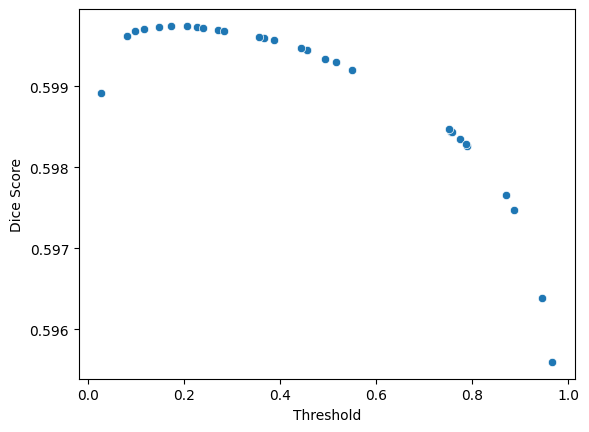

In [83]:
#Plot the dice scores as a scatterplot
import seaborn as sns
sns.scatterplot(x=thresholds, y=scores)
#Set x axis
plt.xlabel("Threshold")
plt.ylabel("Dice Score")

Submission

In [82]:
from tqdm import tqdm
import tifffile 
from pathlib import Path
# Create a submission file of the predictions (store single-band TIF files with predictions of each image in test_predictions)
loc = "zip/"
#Create the dir
if not os.path.exists(loc):
    os.makedirs(loc)
    
    
#Remove all files from zip
for file in os.listdir(loc):
    os.remove(os.path.join(loc, file))

for i, (pred, filename) in tqdm(enumerate(zip(test_predictions, file_list[2]))):
    files = filename.split("_")
    filename = files[0] + "_kelp.tif"
    #Set replace values above 0.5 to be 1 and below 0.5 to be 0 of pred
    pred[pred > best_threshold] = 1
    pred[pred <= best_threshold] = 0
    #Save the prediction as tiff file
    #Threshold the 
    tifffile.imwrite(os.path.join(loc, filename), pred[1].reshape(1, pred.shape[1], pred.shape[2]))
    
#Create a zip file of all files in loc
import zipfile
with zipfile.ZipFile("submission.zip", "w") as zipped:
    files = Path(loc).rglob('*.tif') #get all files.
    for file in files:
        zipped.write(file, file.name)



1426it [00:02, 599.83it/s]
